In [1]:
suppressMessages(require(Seurat))
suppressMessages(require(ggplot2))
suppressMessages(require(dplyr))
suppressMessages(require(reticulate))
suppressMessages(require(stringr))
suppressMessages(require(ggpubr))
suppressMessages(require(viridisLite))
suppressMessages(require(SeuratDisk))

In [2]:
source('modules/reformatProjRes.R')
source('benchmarking/readBenchmarkRes.R')

In [3]:
out.figs.dir <- '../2.results/review01/figs'
out.data.dir <- '../2.results/review01/data'

In [4]:
RMSE = function(m, o){
  sqrt(mean((m - o)^2))
}

In [5]:
data_summary <- function(data, varname, groupnames){
  require(plyr)
  summary_func <- function(x, col){
    c(mean = mean(x[[col]], na.rm=TRUE),
      sd = sd(x[[col]], na.rm=TRUE))
  }
  data_sum<-ddply(data, groupnames, .fun=summary_func,
                  varname)
  data_sum <- rename(data_sum, c("mean" = varname))
 return(data_sum)
}

### Loading dataset: Lambda = 5

In [6]:
decon.tools <- c("Cell2location", "SpatialDWLS", "RCTD", "Stereoscope", "DestVI", "SpaOTsc", "novoSpaRc", "SPOTlight", "CARD", "DSTG")
seg.tools <- c("Cell2Spatial", "CellTrek", "CytoSPACE", "Tangram", "Seurat")

In [7]:
COLS <- c(
    Cell2Spatial = '#7C8E7D',
    CytoSPACE = '#E18EE2',
    CellTrek = '#E2B199',
    Tangram = '#DAD3E5',
    Seurat = '#E2DB8F',
    Cell2location = '#899CC8',
    SpatialDWLS = '#6C70ED',
    RCTD = '#E3ED34',
    Stereoscope = '#C6DEC2',
    DestVI = '#A3A1B2',
    SpaOTsc = '#F3CDDF',
    novoSpaRc = '#9E0018',
    SPOTlight = '#888570',
    CARD = '#A0C669',
    DSTG = '#C6C6A2'
)

In [8]:
obj.sc <- readRDS('benchmarking/data/allen_cortex.rds')
obj.st <- readRDS('benchmarking/data/stxBrain.sim.5.rds')

### END to END mapping

In [9]:
sim.true <- readRDS('../2.results/stxBrain/data/stxBrain.true.coord.rds')

In [10]:
sim.true$CellType <- as.vector(sim.true$CellType)

In [59]:
spot.counts <- lapply(split(sim.true$CellName, sim.true$SpotID), length) %>% unlist
saveRDS(spot.counts, file = 'benchmarking/data/end.to.end/spot.counts.RDS')

In [11]:
sc.count <- GetAssayData(obj.sc, slot = 'count')[, sim.true$CellName] %>% as.matrix
colnames(sc.count) <- paste0(colnames(sc.count), '_F', 1 : ncol(sc.count))
sim.true$CellNameNew <- colnames(sc.count)
rownames(sim.true) <- sim.true$CellNameNew
head(sim.true)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 4.8 GiB”


,CellName,SpotID,row,col,x.new,y.new,CellType,CellNameNew
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
F2S4_170130_007_D01_F1,F2S4_170130_007_D01,AAACAAGTATCTCCCA-1,385.9725,438.9501,387.7670,439.9820,Oligo,F2S4_170130_007_D01_F1
F2S4_170201_014_G01_F2,F2S4_170201_014_G01,AAACAAGTATCTCCCA-1,385.9725,438.9501,385.5167,439.0420,Oligo,F2S4_170201_014_G01_F2
F2S4_160811_001_C01_F3,F2S4_160811_001_C01,AAACAAGTATCTCCCA-1,385.9725,438.9501,387.5535,439.4452,Pvalb,F2S4_160811_001_C01_F3
F2S4_171128_002_E01_F4,F2S4_171128_002_E01,AAACAAGTATCTCCCA-1,385.9725,438.9501,386.8448,435.9195,Pvalb,F2S4_171128_002_E01_F4
F2S4_170511_001_G01_F5,F2S4_170511_001_G01,AAACAAGTATCTCCCA-1,385.9725,438.9501,386.5805,436.1109,Pvalb,F2S4_170511_001_G01_F5
F2S4_171201_006_G01_F6,F2S4_171201_006_G01,AAACAAGTATCTCCCA-1,385.9725,438.9501,385.8109,438.6173,Pvalb,F2S4_171201_006_G01_F6


In [48]:
idxes <- sample(nrow(sc.count), floor(nrow(sc.count) * 10 * 0.01))
rand.shuffle <- sc.count[idxes, ]
rand.shuffle <- rand.shuffle[, sample(ncol(rand.shuffle))]
colnames(rand.shuffle) <- colnames(sc.count)
sc.count[idxes, ] <- rand.shuffle

In [50]:
obj.sc.test <- CreateSeuratObject(counts = sc.count, meta.data = sim.true)
saveRDS(obj.sc.test, file = 'benchmarking/data/end.to.end/obj.sc.test.RDS')

In [212]:
diff.cells <- setdiff(colnames(obj.sc), gsub('_F\\d+', '', colnames(obj.sc.test))) 
obj.sc.train <- obj.sc[, diff.cells]
obj.sc.train$CellType <- obj.sc.train$subclass
saveRDS(obj.sc.train, file = 'benchmarking/data/end.to.end/obj.sc.train.RDS')

In [211]:
table(obj.sc.train$subclass)


     Astro         CR       Endo    L2/3 IT         L4      L5 IT      L5 PT 
       322          5         92        897       1352        792        488 
     L6 CT      L6 IT        L6b      Lamp5 Macrophage      Meis2         NP 
       879       1813        327       1115         51         19        353 
     Oligo       Peri      Pvalb        SMC   Serpinf1       Sncg        Sst 
        68         32       1285         55         26        124       1652 
      VLMC        Vip 
        57       1725 

In [54]:
SaveH5Seurat(UpdateSeuratObject(obj.sc.test), filename = sprintf("benchmarking/data/end.to.end/%s.h5Seurat", 'obj.sc.test'), overwrite = TRUE)

Validating object structure

Updating object slots

Ensuring keys are in the proper structure

Ensuring feature names don't have underscores or pipes

Object representation is consistent with the most current Seurat version

Warning message:
“Overwriting previous file benchmarking/data/end.to.end/obj.sc.test.h5Seurat”
Creating h5Seurat file for version 3.1.5.9900

Adding counts for RNA

Adding data for RNA

No variable features found for RNA

No feature-level metadata found for RNA



In [55]:
Convert(sprintf("benchmarking/data/end.to.end/%s.h5Seurat", 'obj.sc.test'), dest = "h5ad", overwrite = TRUE)

Validating h5Seurat file

Adding data from RNA as X

Adding counts from RNA as raw

Transfering meta.data to obs



In [203]:
jaccardAcc <- function(sim.true, map.lst) {
    true.lst <- split(sim.true$CellNameNew, sim.true$SpotID)
    res <- lapply(names(map.lst), function(tool) {
        qry.lst <- map.lst[[tool]]
        lapply(names(true.lst), function(spot) {
            length(intersect(true.lst[[spot]], qry.lst[[spot]])) / length(union(true.lst[[spot]], qry.lst[[spot]]))
        }) %>% unlist(.) %>% as.vector     
    }) %>% do.call(cbind, .) %>% `colnames<-`(names(map.lst))
    return(res)
}

In [274]:
out.dir <- 'benchmarking/results2/Sim.0'
obj.sc.test <- readRDS('benchmarking/data/end.to.end/obj.sc.test.RDS')
obj.st.test <- readRDS('benchmarking/data/end.to.end/stxBrain.sim.0.rds')
map.lst <- readMappingData(obj.sc.test, obj.st.test, sim.true, out.dir)

res.1 <- jaccardAcc(sim.true, map.lst)

In [275]:
out.dir <- 'benchmarking/results2/Sim.5'
obj.sc.test <- readRDS('benchmarking/data/end.to.end/obj.sc.test.RDS')
obj.st.test <- readRDS('benchmarking/data/end.to.end/stxBrain.sim.5.rds')
map.lst <- readMappingData(obj.sc.test, obj.st.test, sim.true, out.dir)

res.2 <- jaccardAcc(sim.true, map.lst)

In [276]:
out.dir <- 'benchmarking/results2/Sim.10'
obj.sc.test <- readRDS('benchmarking/data/end.to.end/obj.sc.test.RDS')
obj.st.test <- readRDS('benchmarking/data/end.to.end/stxBrain.sim.10.rds')
map.lst <- readMappingData(obj.sc.test, obj.st.test, sim.true, out.dir)

res.3 <- jaccardAcc(sim.true, map.lst)

In [277]:
out.dir <- 'benchmarking/results2/Sim.15'
obj.sc.test <- readRDS('benchmarking/data/end.to.end/obj.sc.test.RDS')
obj.st.test <- readRDS('benchmarking/data/end.to.end/stxBrain.sim.15.rds')
map.lst <- readMappingData(obj.sc.test, obj.st.test, sim.true, out.dir)

res.4 <- jaccardAcc(sim.true, map.lst)

In [278]:
out.dir <- 'benchmarking/results2/Sim.20'
obj.sc.test <- readRDS('benchmarking/data/end.to.end/obj.sc.test.RDS')
obj.st.test <- readRDS('benchmarking/data/end.to.end/stxBrain.sim.20.rds')
map.lst <- readMappingData(obj.sc.test, obj.st.test, sim.true, out.dir)

res.5 <- jaccardAcc(sim.true, map.lst)

In [279]:
plot.df <- rbind.data.frame(
    Sim.0 = apply(res.1, 2, mean),
    Sim.5 = apply(res.2, 2, mean),
    Sim.10 = apply(res.3, 2, mean),
    Sim.15 = apply(res.4, 2, mean),
    Sim.20 = apply(res.5, 2, mean)
) %>% `rownames<-`(c('Sim.0', 'Sim.5', 'Sim.10', 'Sim.15', 'Sim.20')) %>% `colnames<-`(names(map.lst)) %>% t

In [258]:
#plot.df <- sweep(plot.df, 2, apply(plot.df, 2, max), '/') %>% as.data.frame
plot.df <- cbind.data.frame(plot.df, Tools = rownames(plot.df))

In [259]:
plot.df.x <- tidyr::gather(plot.df, 'Var1', 'Var2', -Tools)
head(plot.df.x)

,Tools,Var1,Var2
,<chr>,<chr>,<dbl>
1,Cell2Spatial,Sim.0,0.1733136
2,CytoSPACE,Sim.0,0.1078689
3,CellTrek,Sim.0,0.1931949
4,Tangram,Sim.0,0.1549259
5,Cell2Spatial,Sim.5,0.1692817
6,CytoSPACE,Sim.5,0.1142684


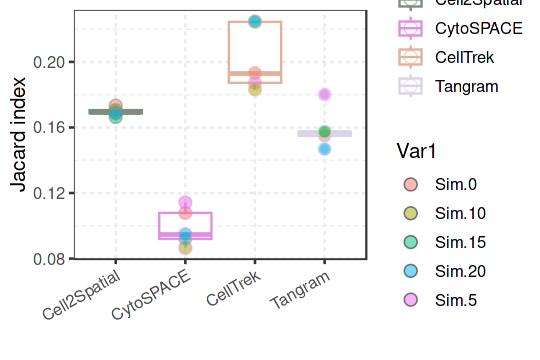

In [296]:
options(repr.plot.width = 4.5, repr.plot.height = 3)
plot.df.x$Tools <- factor(plot.df.x$Tools, levels = names(map.lst))
ggplot(plot.df.x, aes(x = Tools, y = Var2, color = Tools)) + geom_boxplot() + geom_point(aes(fill = Var1), shape = 21, size = 3, alpha = .5)  + xlab('') + theme_bw(base_size = 12) + theme(panel.grid = element_line(linetype = 'dashed'), axis.text.x = element_text(angle = 30, hjust = 1)) + ylab('Jacard index') + scale_color_manual(values = COLS[names(map.lst)]) 
ggsave(file.path(out.figs.dir, 'jacard.index.acc.pdf'), width = 4.5, height = 3)

In [238]:
openxlsx::write.xlsx(as.data.frame(plot.df), file = file.path(out.data.dir, 'end.to.end.acc.xlsx'), rowNames = TRUE)

### Perfermance evaluation for different group size.

In [431]:
hvgConserve <- function(obj.lst, ref.obj) {
    DefaultAssay(ref.obj) <- 'Spatial'
    #ref.obj <- ref.obj %>% NormalizeData(verbose = FALSE) %>% FindVariableFeatures(nfeatures = nfeatures, verbose = FALSE)
    ref.obj <- ref.obj %>% SCTransform(verbose = FALSE, assay = 'Spatial', variable.features.n = 2000)
    ref.hvgs <- VariableFeatures(ref.obj)
    hvg.res <- lapply(obj.lst, function(qry.obj) {
        DefaultAssay(qry.obj) <- 'RNA'
        #qry.obj <- qry.obj %>% NormalizeData(verbose = FALSE) %>% FindVariableFeatures(nfeatures = nfeatures, verbose = FALSE)
        qry.obj <- qry.obj %>% SCTransform(verbose = FALSE, variable.features.n = 2000)
        qry.hvgs <- VariableFeatures(qry.obj)
        length(intersect(ref.hvgs, qry.hvgs)) / min(length(ref.hvgs), length(qry.hvgs))
    }) %>% unlist %>% as.vector
    return(hvg.res)
}

In [341]:
exprDecom <- function (obj) 
{
    sp.lst <- split(obj$Cell, obj$SpotName)
    sc.mat <- GetAssayData(obj, slot = "count")
    mat <- parallel::mclapply(sp.lst, function(xx) {
        if (length(xx) > 1) 
            rowSums(sc.mat[, xx])
        else sc.mat[, xx]
    }, mc.cores = 2) %>% do.call(cbind, .) %>% as.data.frame
    obj.cell2spatial <- CreateSeuratObject(count = mat) 
    return(obj.cell2spatial)
}

In [298]:
obj.lst <- readRDS('test.group.size/sce.lst.RDS')

In [311]:
labels <- seq(10, 200, 10) %>% paste0('gsize.', .)
names(obj.lst) <- labels

In [342]:
obj.lst.new <- lapply(obj.lst, function(obj) { exprDecom(obj) })

In [363]:
ref.obj <- readRDS('../0.data/stxBrain/brain.st.rds')
ovp.genes <- intersect(rownames(ref.obj), rownames(obj.lst.new[[1]]))
ref.obj <- ref.obj[ovp.genes, ]

In [393]:
hvg.res <- hvgConserve(obj.lst.new, ref.obj)

In [396]:
names(hvg.res) <- labels

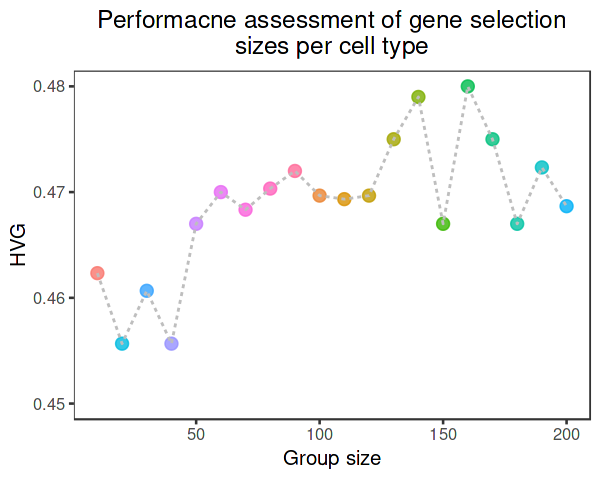

In [439]:
options(repr.plot.width = 5, repr.plot.height = 4)
plot.df <- cbind.data.frame(HVG = hvg.res, Gsize = seq(10, 200, 10), Label = labels)
ggplot(plot.df, aes(x = Gsize, y = HVG)) + geom_point(aes(color = labels), size = 3, alpha = 0.8) + geom_line(linetype = 'dashed', color = 'grey', linewidth = 0.6) + ylim(0.45, 0.48) + theme_bw(base_size = 12) + theme(panel.grid = element_blank(), legend.position = 'none', plot.title = element_text(hjust = 0.5)) + xlab('Group size') + ggtitle('Performacne assessment of gene selection\nsizes per cell type')

ggsave(file.path(out.figs.dir, 'gsize.assesment.pdf'), width = 5, height = 4)

openxlsx::write.xlsx(as.data.frame(plot.df), file = file.path('gsize.assesment.xlsx'), rowNames = TRUE)

In [633]:
sd(hvg.res)

[1] 0.006478575

In [440]:
unique(obj.lst[[10]]$Cell2Spatial)

[1] "Oligo"      "Astro"      "L2/3 IT"    "Meis2"      "Sst"       
 [6] "Sncg"       "CR"         "Macrophage" "Endo"       "Pvalb"     
[11] "L4"         "L5 IT"      "L6 CT"      "L6b"        "L6 IT"     
[16] "L5 PT"      "Lamp5"      "VLMC"       "SMC"        "Serpinf1"  
[21] "NP"         "Peri"       "Vip"

### Extract some cell types for assessing the performance of tools.

In [502]:
cols.sub <- c('Astro' = '#DB54E2', `L2/3 IT` = '#7C8E7D', 'L4' = '#E18EE2')

In [461]:
source('modules/utils.R')

In [442]:
obj.sc.sub <- readRDS('benchmarking/data/subclass/allen_cortex.rds')
obj.sp <- readRDS('benchmarking/data/subclass/brain.st.rds')

In [484]:
cyto.obj <- forCytoSpace('benchmarking/results4/cytospace.brain.st/', obj.sc = obj.sc.sub, obj.st = obj.sp)

In [485]:
tangram.obj <- forTangram('benchmarking/results4/Tangram_map2space.xls', obj.sc.sub, obj.sp)

In [473]:
celltrek <- readRDS('benchmarking/results4/stxBrain.celltrek.RDS')
celltrek.obj <- forCellTrek(list(xx = celltrek), obj.sc.sub, obj.sp)

In [615]:
cell2sp.obj <- readRDS('benchmarking/results4/cell2spatial.unmatched.RDS')

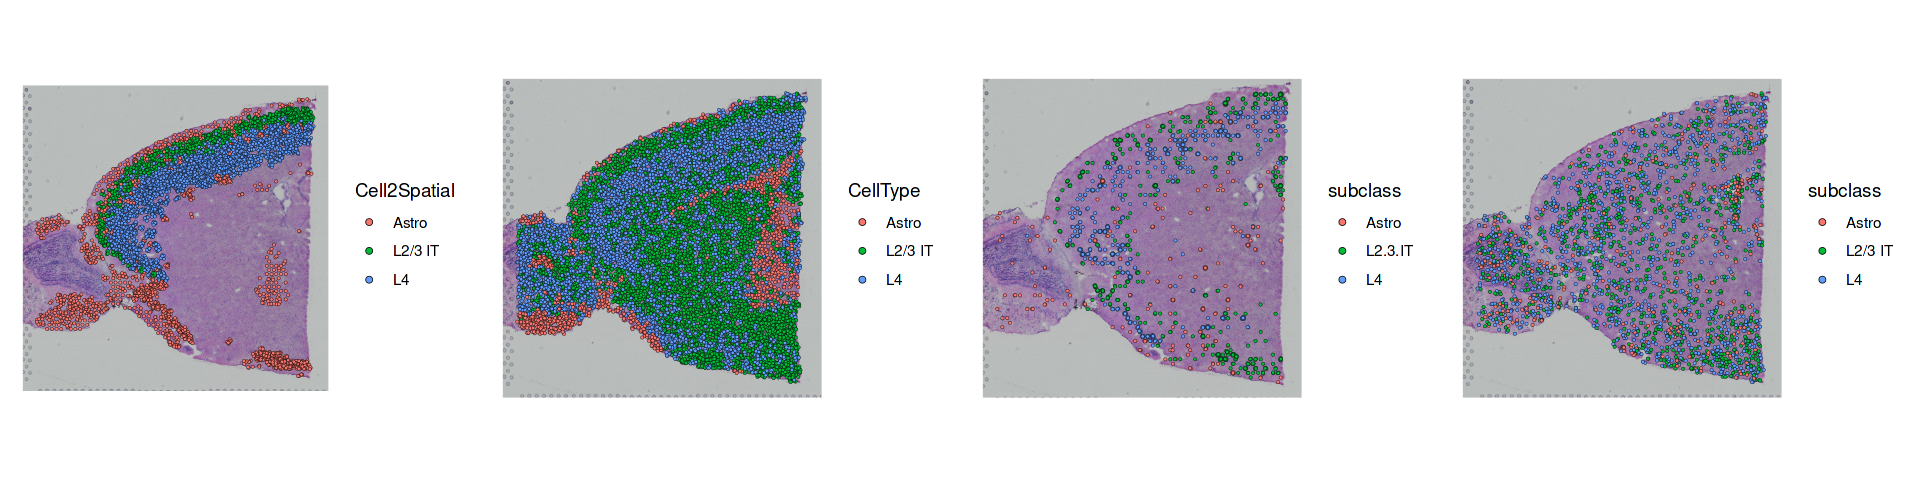

In [616]:
options(repr.plot.width = 16, repr.plot.height = 4)
gp1 <- SpatialPlot(cell2sp.obj, group.by = 'Cell2Spatial', pt.size = 0.8) 
gp2 <- SpatialPlot(cyto.obj, group.by = 'CellType', pt.size = 0.8) 
gp3 <- SpatialPlot(celltrek.obj, group.by = 'subclass', pt.size = 0.8) 
gp4 <- SpatialPlot(tangram.obj, group.by = 'subclass', pt.size = 0.8)

ggarrange(plotlist = list(gp1, gp2, gp3, gp4), ncol = 4)

ggsave(file.path(out.figs.dir, 'subclass.map.to.spatial.pdf'), width = 16, height = 4)

In [617]:
markers <- readRDS('../0.data/sctBrain.markers.RDS')

In [619]:
obj.sp <- AddModuleScore(obj.sp, features = markers)

In [620]:
names(markers)

[1] "Astro"      "CR"         "Endo"       "L2/3 IT"    "L4"        
 [6] "L5 IT"      "L5 PT"      "L6 CT"      "L6 IT"      "L6b"       
[11] "Lamp5"      "Macrophage" "Meis2"      "NP"         "Oligo"     
[16] "Peri"       "Pvalb"      "Serpinf1"   "SMC"        "Sncg"      
[21] "Sst"        "Vip"        "VLMC"

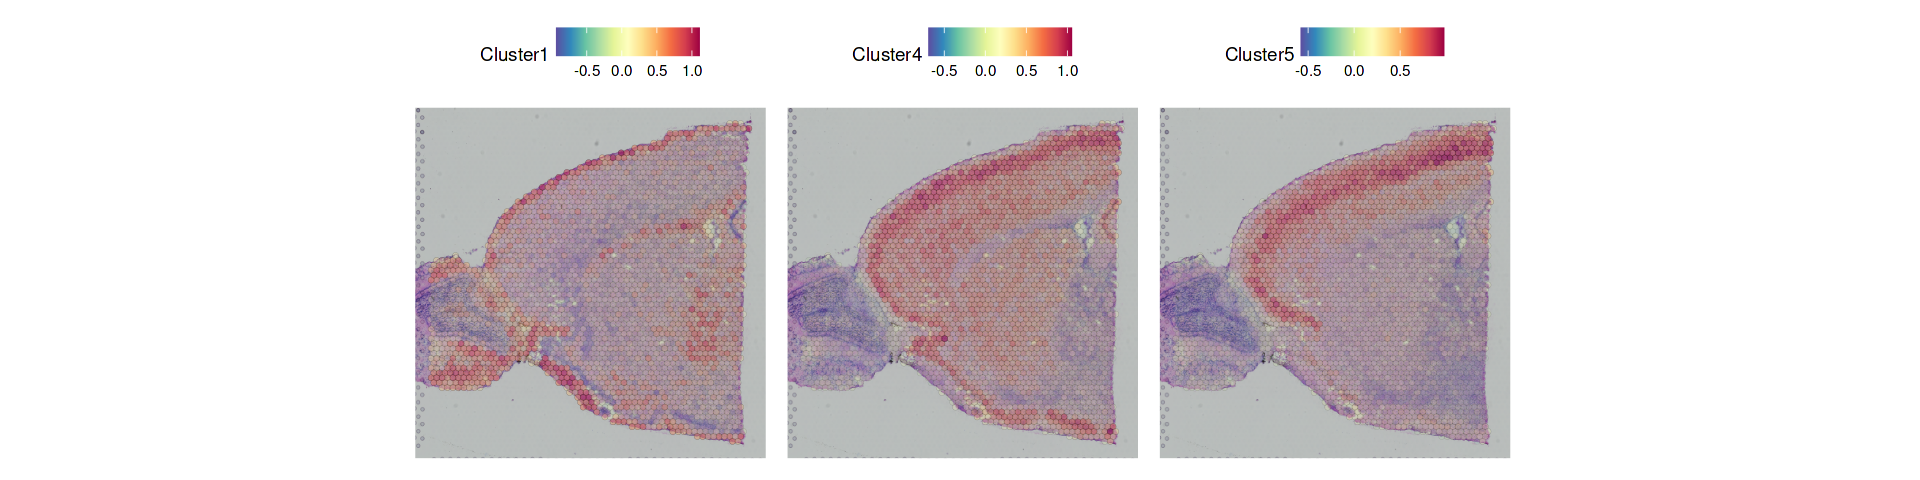

In [629]:
options(repr.plot.width = 16, repr.plot.height = 4)
SpatialFeaturePlot(obj.sp, features = c('Cluster1', 'Cluster4', 'Cluster5'), alpha = c(0.0, 0.5))
#ggsave(file.path)

In [569]:
ture.coord <- readRDS('benchmarking/data/stxBrain.5.true.coord.rds')
head(ture.coord)

,CellName,SpotID,row,col,x.new,y.new,CellType
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
AAACAAGTATCTCCCA-1,F2S4_170130_007_D01,AAACAAGTATCTCCCA-1,385.9725,438.9501,387.7670,439.9820,Oligo
AAACAAGTATCTCCCA-1.1,F2S4_170201_014_G01,AAACAAGTATCTCCCA-1,385.9725,438.9501,385.5167,439.0420,Oligo
AAACAAGTATCTCCCA-1.2,F2S4_171128_002_E01,AAACAAGTATCTCCCA-1,385.9725,438.9501,387.5535,439.4452,Pvalb
AAACAAGTATCTCCCA-1.3,F2S4_160811_001_C01,AAACAAGTATCTCCCA-1,385.9725,438.9501,386.8448,435.9195,Pvalb
AAACAAGTATCTCCCA-1.4,F2S4_170511_001_G01,AAACAAGTATCTCCCA-1,385.9725,438.9501,386.5805,436.1109,Pvalb
AAACAAGTATCTCCCA-1.5,F2S4_171201_006_G01,AAACAAGTATCTCCCA-1,385.9725,438.9501,385.8109,438.6173,Pvalb


In [571]:
createSpatialObject <- function(counts, coord.df, class = "SlideSeq") {
    ovp.spots <- intersect(colnames(counts), rownames(coord.df))
    if (length(ovp.spots) == 0) println("No shared barcodes between count matrix and coordinates", verbose = TRUE, status = "ERROR")
    obj.seu <- CreateSeuratObject(counts = counts[, ovp.spots], assay = "Spatial")
    obj.seu@images$image <- new(
        Class = class,
        assay = "Spatial",
        key = "image_",
        coordinates = coord.df[ovp.spots, ]
    )
    return(obj.seu)
}

In [574]:
count.sc <- GetAssayData(obj.sc, slot = "count")
count.CT <- as(count.sc[, ture.coord$CellName], "sparseMatrix")
colnames(count.CT) <- rownames(ture.coord)

coords <- data.frame(imagerow = ture.coord$x.new, imagecol = ture.coord$y.new) %>% `rownames<-`(rownames(ture.coord))
sce <- createSpatialObject(count = count.CT, coord.df = coords)
sce@meta.data <- ture.coord

In [576]:
options(repr.plot.width = 6, repr.plot.height = 6)
gp <- SpatialPlot(subset(sce, CellType %in% c('Astro', 'L2/3 IT', 'L4')), group.by = 'CellType')

### Memory and time usages 

In [577]:
dirs <- paste0('sim.', seq(1000, 10000, 1000))
dirs

[1] "sim.1000"  "sim.2000"  "sim.3000"  "sim.4000"  "sim.5000"  "sim.6000" 
 [7] "sim.7000"  "sim.8000"  "sim.9000"  "sim.10000"

In [586]:
plot.df <- lapply(dirs, function(xx) {
    x1 <- readRDS(file.path('benchmarking/results3', xx, 'cell2spatial.unmatched.RDS'))[2 : 4]
    x2 <- readRDS(file.path('benchmarking/results3', xx, 'cytospace_result.RDS'))[2 : 4]
    x3 <- readRDS(file.path('benchmarking/results3', xx, 'seurat_result.RDS'))[2 : 4]
    x4 <- readRDS(file.path('benchmarking/results3', xx, 'stxBrain.celltrek.RDS'))[2 : 4]
    x5 <- read.table(file.path('benchmarking/results3', xx, 'performance_metrics.txt'))[, 4]
    rbind.data.frame(
        cbind.data.frame(x1, Tool = 'Cell2Spatial', Spot.Size = as.integer(gsub('sim.', '', xx))),
        cbind.data.frame(x2, Tool = 'CytoSPACE', Spot.Size = as.integer(gsub('sim.', '', xx))),
        cbind.data.frame(x3, Tool = 'Seurat', Spot.Size = as.integer(gsub('sim.', '', xx))),
        cbind.data.frame(x4, Tool = 'CellTrek', Spot.Size = as.integer(gsub('sim.', '', xx))),
        c(x5, Tool = 'Tangram', Spot.Size = as.integer(gsub('sim.', '', xx)))
    )
}) %>% do.call(rbind, .)

In [587]:
head(plot.df)

,Elapsed_Time_sec,Total_RAM_Used_MiB,Peak_RAM_Used_MiB,Tool,Spot.Size
,<chr>,<chr>,<chr>,<chr>,<chr>
1,373.37,11,5191.0728225708,Cell2Spatial,1000
2,587.23,0.0999999999999091,8819.3,CytoSPACE,1000
3,198.565,272.9,13452.9,Seurat,1000
4,127.662,307,5734.8,CellTrek,1000
5,3162.86,7625.74,10503.26,Tangram,1000
6,581.235,11.0999999999999,9897.83943939209,Cell2Spatial,2000


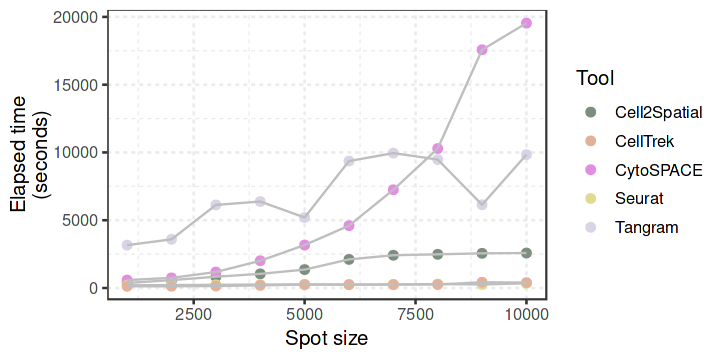

In [606]:
options(repr.plot.width = 6, repr.plot.height = 3)
plot.df$Elapsed_Time_sec <- as.numeric(plot.df$Elapsed_Time_sec)
plot.df$Spot.Size <- as.integer(plot.df$Spot.Size)
ggplot(plot.df, aes(x = Spot.Size, y = Elapsed_Time_sec, group = Tool, color = Tool)) + geom_point(size = 2) + geom_line(color = 'grey') + theme_bw(base_size = 12) + theme(panel.grid = element_line(linetype = 'dashed')) + scale_color_manual(values = COLS[unique(plot.df$Tool)]) + ylab('Elapsed time\n(seconds)') + xlab('Spot size')

ggsave(file.path(out.figs.dir, 'eplased.time.for.tools.pdf'), width = 6, height = 3)

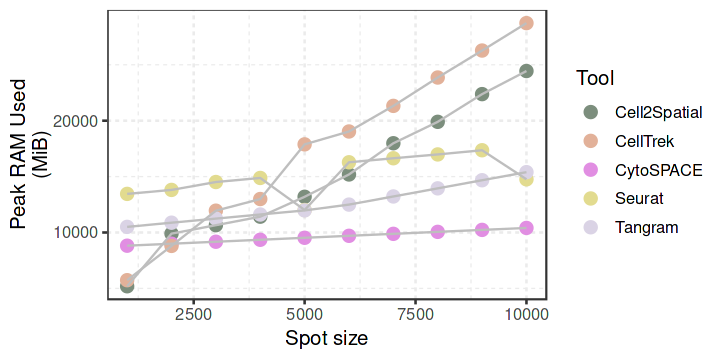

In [602]:
options(repr.plot.width = 6, repr.plot.height = 3)
plot.df$Peak_RAM_Used_MiB <- as.numeric(plot.df$Peak_RAM_Used_MiB)
plot.df$Spot.Size <- as.integer(plot.df$Spot.Size)
ggplot(plot.df, aes(x = Spot.Size, y = Peak_RAM_Used_MiB, group = Tool, color = Tool)) + geom_point(size = 3) + geom_line(color = 'grey') + theme_bw(base_size = 12) + theme(panel.grid = element_line(linetype = 'dashed')) + scale_color_manual(values = COLS[unique(plot.df$Tool)]) + ylab('Peak RAM Used\n(MiB)') + xlab('Spot size')

ggsave(file.path(out.figs.dir, 'Peak_RAM_Used_MiB.for.tools.pdf'), width = 6, height = 3)

In [603]:
openxlsx::write.xlsx(plot.df, file = file.path(out.data.dir, 'eplased.time.for.tools.xlsx'), rowNames = TRUE)

In [603]:
sessionInfo()

R version 4.4.0 (2024-04-24)
Platform: x86_64-pc-linux-gnu
Running under: Ubuntu 22.04.2 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3 
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/libopenblasp-r0.3.20.so;  LAPACK version 3.10.0

locale:
 [1] LC_CTYPE=C.UTF-8    LC_NUMERIC=C        LC_TIME=C          
 [4] LC_COLLATE=C        LC_MONETARY=C       LC_MESSAGES=C      
 [7] LC_PAPER=C          LC_NAME=C           LC_ADDRESS=C       
[10] LC_TELEPHONE=C      LC_MEASUREMENT=C    LC_IDENTIFICATION=C

time zone: Asia/Chongqing
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] SeuratDisk_0.0.0.9020 plyr_1.8.9            viridisLite_0.4.2    
 [4] ggpubr_0.6.0          stringr_1.5.1         reticulate_1.37.0    
 [7] dplyr_1.1.4           ggplot2_3.5.1         SeuratObject_4.1.4   
[10] Seurat_4.4.0         

loaded via a namespace (a